The purpose of this notebook is to gather historical streamflow data for the reaches defined by our GIS layers.

In [1]:
import s3fs
import urllib3
import requests
import xarray
import pandas
from dask.distributed import Client

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

In [2]:
# use a try accept loop so we only instantiate the client
# if it doesn't already exist.
try:
    print(client.dashboard_link)
except:    
    # The client should be customized to your workstation resources.
    # This is configured for a "Large" instance on ciroh.awi.2i2c.cloud
    # client = Client()
    client = Client(n_workers=10, memory_limit='20GB')
    print(client.dashboard_link)

/user/castronova/proxy/8787/status


In [3]:
base_url = "https://arcgis.cuahsi.org/arcgis/rest/services/CIROH-ComRes"
def collect_reaches_from_gis_layers():
    # the following indices correspond to the Flowlines layer
    locations = {
        "DeSoto": 0,
        "MountAscutney": 0,
        "RoaringRiver": 13,
        "SpringfieldGreeneCounty": 1,
        "TwoRiversOttauquechee": 0,
        "Windham": 0,
    }
    params = {
        "where": "1=1",
        "geometryType": "esriGeometryEnvelope",
        "spatialRel": "esriSpatialRelIntersects",
        "units": "esriSRUnit_Foot",
        "outFields": "COMID,REACHCODE",
        "returnGeometry": "false",
        "returnDistinctValues": "true",
        "returnIdsOnly": "false",
        "returnCountOnly": "false",
        "returnExtentOnly": "false",
        "returnZ": "false",
        "returnM": "false",
        "multipatchOption": "xyFootprint",
        "returnTrueCurves": "false",
        "returnExceededLimitFeatures": "false",
        "returnCentroid": "false",
        "timeReferenceUnknownClient": "false",
        "sqlFormat": "none",
        "featureEncoding": "esriDefault",
        "f": "json",
    }

    riverids = {}
    for locname, layerid in locations.items():
        response = requests.get(
            f"{base_url}/{locname}/FeatureServer/{layerid}/query",
            params=params,
            verify=False,
        )

        data = response.json()
        if "error" in data.keys():
            print(
                f"\n * Error: {locname} - {data['error']['code']} - {data['error']['message']}\n"
            )
            continue

        comids = []
        if "features" in data:
            for feature in data["features"]:
                if "attributes" in feature and "COMID" in feature["attributes"]:
                    comids.append(
                        {
                            "reachid": feature["attributes"]["COMID"],
                            "huc8": feature["attributes"]["REACHCODE"][0:8],
                        }
                    )

        riverids[locname] = comids
        print(f"Found {len(comids)} rivers in {locname}")

    return riverids


In [4]:
reaches = collect_reaches_from_gis_layers()

Found 551 rivers in DeSoto
Found 1163 rivers in MountAscutney
Found 323 rivers in RoaringRiver
Found 1704 rivers in SpringfieldGreeneCounty
Found 1945 rivers in TwoRiversOttauquechee
Found 1352 rivers in Windham


In [5]:
%%time
# load historical streamflow data via retrospective
zarr_url = 's3://noaa-nwm-retrospective-3-0-pds/CONUS/zarr/chrtout.zarr'

# Create an anonymous S3 filesystem
fs = s3fs.S3FileSystem(anon=True)

# Pass the filesystem to xarray
ds = xarray.open_zarr(fs.get_mapper(zarr_url), consolidated=True)

#ds = xarray.open_zarr(zarr_url, consolidated=True)

CPU times: user 4.09 s, sys: 782 ms, total: 4.87 s
Wall time: 15.1 s


In [6]:
for region_name in [#'DeSoto',
                    #'MountAscutney',
                    #'RoaringRiver',
                    'SpringfieldGreeneCounty',
                    'TwoRiversOttauquechee',
                    'Windham']:


    # region_name = 'MountAscutney'
    reach_ids = [reach["reachid"] for reach in reaches[region_name]]
    print(f'Found {len(reach_ids)} reach ids for {region_name}')

    
    # only search data for ids that exist in the dataset
    existing_ids = set(ds.feature_id.values)
    valid_ids = [rid for rid in reach_ids if rid in existing_ids]
    missing_ids = list(set(reach_ids) - set(valid_ids))
    with open(f'{region_name}_missing.txt', 'w') as f:
        for mid in missing_ids:
            f.write(f'{mid}\n')
    
    # select data that matches our reach_ids, silently drop any that are not found.
    dat = ds.sel(feature_id=valid_ids, drop=True).streamflow 

    # rechunk
    target_feature_chunk = 1000    # roughly matches the number of feature IDs
    target_time_chunk = -1         # one big chunk over time
    dat = dat.chunk({'time': -1, 'feature_id': 1000})

    result = dat.compute()

    da_clean = result.drop_vars([c for c in result.coords if c not in ['time', 'feature_id']])

    
    # save to disk
    df = da_clean.to_dataframe(name='streamflow').reset_index()
    df.to_parquet(f'{region_name}.parquet')


Found 1704 reach ids for SpringfieldGreeneCounty
Found 1945 reach ids for TwoRiversOttauquechee
Found 1352 reach ids for Windham


In [ ]:
"""
    # # compute quantiles
    # percentiles = [0.05, 0.10, 0.25, 0.75, 0.95]
    # q = dat.quantile(percentiles, dim="time")
    # mx = dat.max(dim="time")      
    
    # # combine before computing
    # final = xarray.concat([q, mx.expand_dims({'quantile': ['max']})], dim='quantile')
"""

In [ ]:
#result.sel(feature_id = 6090109, quantile=0.75).values

Make a plot similar to the one below.

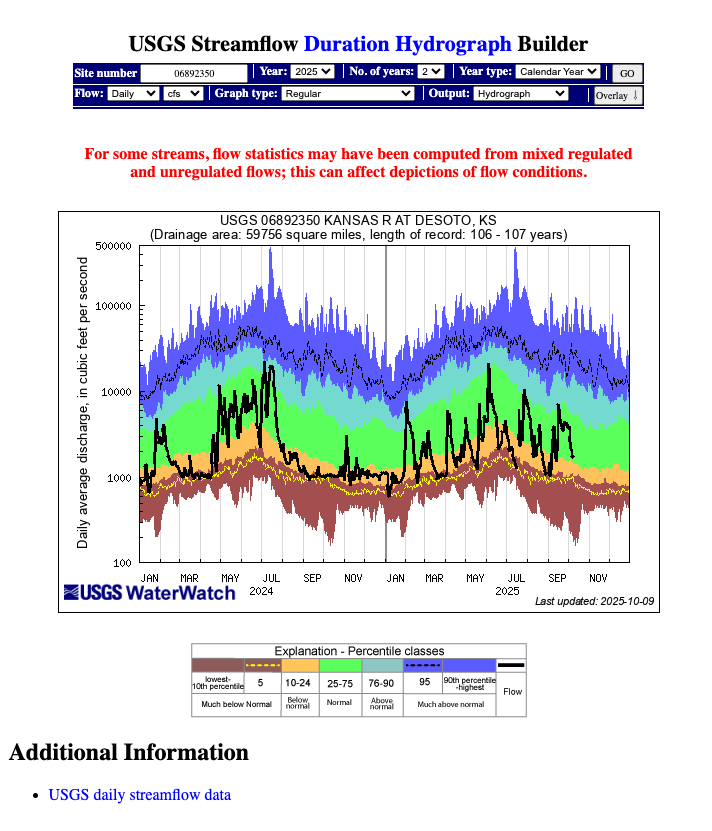

In [15]:
df = pandas.read_parquet('DeSoto.parquet')

In [16]:
df

,time,feature_id,streamflow
0,1979-02-01 01:00:00,3629135,3964.359911
1,1979-02-01 01:00:00,3629127,3963.069911
2,1979-02-01 01:00:00,3629119,3963.079911
3,1979-02-01 01:00:00,3629097,3963.109911
4,1979-02-01 01:00:00,3629089,3963.069911
...,...,...,...
211365787,2023-02-01 00:00:00,3629109,0.020000
211365788,2023-02-01 00:00:00,3629107,0.020000
211365789,2023-02-01 00:00:00,3629141,0.030000
211365790,2023-02-01 00:00:00,3629145,0.060000
